# Single trace FWI sensitivity kernel example
1. generate forward modeled data with a velocity of 1600m/s (true_model)
1. generate forward modeled data with a velocity of 1500m/s (slow_model)
1. backproject the residual (true_model - slow_model) ... the fwi gradient

In [2]:
using PyPlot, Jets, WaveFD, JetPackWaveFD

┌ Info: Precompiling WaveFD [44f9e87b-acd6-44e6-b5b0-e1db9a6b2dd4]
└ @ Base loading.jl:1278
┌ Info: Precompiling JetPackWaveFD [30ac78e6-0b88-494d-b61b-9674962a0c3e]
└ @ Base loading.jl:1278


In [10]:
v = ones(Float32,176,851).*1600;
vₒ = ones(Float32,176,851).*1500;
dz,dx = 20.0,20.0
nz,nx = size(v)
@show dz,dx
@show nz,nx;

(dz, dx) = (20.0, 20.0)
(nz, nx) = (176, 851)


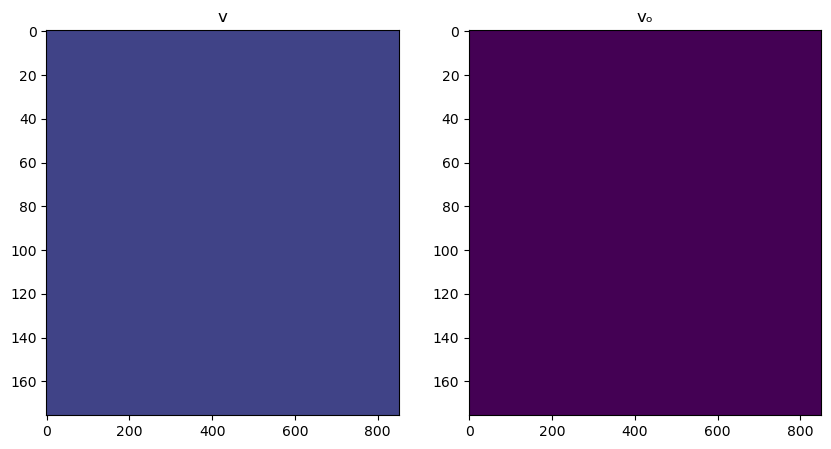

In [12]:
figure(figsize=(10,5))
subplot(121);imshow(v,aspect="auto");title("v");clim(1500,2000);
subplot(122);imshow(vₒ,aspect="auto");title("vₒ");clim(1500,2000);

In [13]:
F = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
    b = ones(Float32,size(v)),
    nthreads = Sys.CPU_THREADS,
    isinterior = true,
    nsponge = 80,
    ntrec = 3001,
    dtrec = 0.004,
    dtmod = 0.002,
    dz = dz,
    dx = dx,
    wavelet = WaveletCausalRicker(f=5.0),
    sx = dx*(100),
    sz = dz,
    rx = [dx*(nx-100)],
    rz = [dz])

&quot;Jet nonlinear operator, (176, 851) → (3001, 1)&quot;

In [14]:
d = F*v;
dₒ = F*vₒ;

┌ Info: nonlinear forward on cbox-nhwq-standard, srcfieldfile=/tmp/field-4f985a81-abae-4c48-a7c9-1d4c82353ff0.bin
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:387
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step     1 of  6001 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%) -- rms d,p; 0.0000e+00 0.0000e+00
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:703
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step   500 of  6001 ;  112.05 MCells/s (IO=46.15%, EX=32.61%) -- rms d,p; 0.0000e+00 7.8127e-01
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:703
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1000 of  6001 ;  126.48 MCells/s (IO=45.05%, EX=30.09%) -- rms d,p; 0.0000e+00 5.6664e-01
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:703
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, no

In [15]:
r = d .- dₒ
J = jacobian(F, vₒ)
dv = J' * r;

┌ Info: linear adjoint on cbox-nhwq-standard, srcfieldfile=/tmp/field-4f985a81-abae-4c48-a7c9-1d4c82353ff0.bin
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:626
┌ Info: PropLn2DAcoIsoDenQ_DEO2_FDTD, adjoint, time step     1 of  6001 ;    0.00 MCells/s (IO= 0.00%, EX= 0.00%, IM= 0.00%) -- rms d,p; 3.6672e-02 0.0000e+00
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:693
┌ Info: PropLn2DAcoIsoDenQ_DEO2_FDTD, adjoint, time step     2 of  6001 ;    0.00 MCells/s (IO=33.52%, EX=10.55%, IM=36.27%) -- rms d,p; 3.6672e-02 0.0000e+00
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:693
┌ Info: PropLn2DAcoIsoDenQ_DEO2_FDTD, adjoint, time step   502 of  6001 ;  176.97 MCells/s (IO=25.67%, EX=21.87%, IM=24.20%) -- rms d,p; 3.6672e-02 4.7842e-02
└ @ JetPackWaveFD /home/cvx/.julia/dev/JetPackWaveFD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:693
┌ Info: PropLn2DAcoIsoDenQ_DEO2_

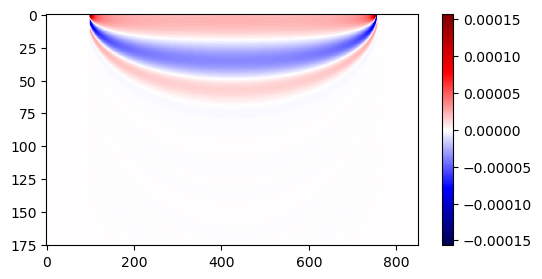

In [20]:
figure(figsize=(6,3))
dmax = maximum(abs,dv)
imshow(dv,aspect="auto", cmap="seismic", clim=0.5 .* [-dmax,dmax]);
colorbar();